<h1><center> Stochastic Primal Dual Hybrid Gradient Algorithm: Tomography </center></h1>

 In this demo, we learn how to use the Stochastic Primal-Dual Hybrid (SPDHG) algorithm, see [here](https://arxiv.org/abs/1706.04957) and [here](https://arxiv.org/abs/1808.07150). This algorithm is a stochastic version of the Primal-Dual Hybrid Gradient Algorithm introduced by [Chambolle & Pock](https://hal.archives-ouvertes.fr/hal-00490826/document). We focus on Tomography Reconstruction under an edge-preserving prior, i.e., the __Total variation regularisation__, see [ROF](https://en.wikipedia.org/wiki/Total_variation_denoising). 

The minimisation problem for Total variation Tomography reconstuction is 

<a id='TomoTV'></a>
$$ \underset{u}{\operatorname{argmin}} \frac{1}{2} \| A u - g\|^{2} + \alpha\,\mathrm{TV}(u) +  \mathbb{I}_{\{u>0\}}(u) $$

where,
1. The total variation is defined as $$\mathrm{TV}(u) = \|\nabla u \|_{2,1} = \sum \sqrt{ (\partial_{y}u)^{2} + (\partial_{x}u)^{2} }$$
1. g is the Acqusisition data obtained from the detector.
1. $A$ is the projection operator ( _Radon transform_ ) that maps from an image-space to an acquisition space, i.e., $A : X \rightarrow Y, $ where X is an __ImageGeometry__ and Y is a __BlockDataContainer__ of __AcquisitionGeometry__ objects.
1. $\alpha$: regularising parameter that measures a trade-off between the fidelity and the regulariser terms.
1. $\mathbb{I}_{\{u>0\}}(u) : = 
\begin{cases}
0, & \mbox{ if } u>0\\
\infty , & \mbox{ otherwise}
\quad
\end{cases}
$, $\quad$ a positivity constraint for the minimiser $u$.

## Learning objectives

1. subsetting 
1. minimal set-up
1. compare PDHG and SPDHG. Notion of epoch.  Visual comparison + primal objective function and/or PSNR
1. how to tweak the minimal set-up: explicit / implicit, stepsizes


## Prerequisites

Pre-requisites:
1. ImageData, AcquisitionData, Blocks
1. Projection operator
1. TV
1. PDHG (so-called implicit set-up for tomographic reconstruction. Optional: explicit set-up)


In order to use the SPDHG algorithm for the problem above, we need to express our minimisation problem into the following form:

<a id='SPDHG_form'></a>
$$\min_{u} \sum_{i=1}^n F_i(K_i u) + G(u)$$

where we assume that:

1. $F_i$, $G$ are __convex__ functionals
    
    - $F_i: Y_i \rightarrow \mathbb{R}$ 
    
    - $G: X \rightarrow \mathbb{R}$
    
    
2. $K_i$ is a continuous linear operator acting from a space X to another space Y_i :

$$K_i : X \rightarrow Y_i \quad $$ 

with operator norm  defined as $$\| K_i \| = \max\{ \|K_i x\|_{Y} : \|x\|_{X}\leq 1 \}.$$  

**Note**: We use the [Power Method](https://en.wikipedia.org/wiki/Power_iteration) to approximate the norm of the $K_i$'s and if needed of $\nabla$.

In [1]:
# Imports
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from cil.framework import ImageData, ImageGeometry, AcquisitionGeometry, AcquisitionData, BlockDataContainer

from cil.optimisation.functions import L2NormSquared, ZeroFunction, L1Norm, BlockFunction, MixedL21Norm, IndicatorBox
from cil.optimisation.operators import GradientOperator, BlockOperator
from cil.optimisation.algorithms import PDHG, SPDHG

from cil.plugins.astra.operators import ProjectionOperator
from cil.plugins.ccpi_regularisation.functions import FGP_TV

import tomophantom
from tomophantom import TomoP2D
import os, sys

import matplotlib.pyplot as plt


import numpy as np

from cil.processors import Slicer
from cil.utilities.display import show2D

%matplotlib inline


## Why SPDHG?

In the previous demo, we presented __PDHG__ for tomography reconstruction.

__SPDHG__ is a stochastic version of __PDHG__. As PDHG, SPDHG can solve convex, non necessarily smooth optimization problems and is provenly convergent. The central improvement with respect to PDHG is that SPDHG can deal with __subsets of data__, making it computationnally more efficient. 

For CT and PET for example, the data can be divided into a collection of partial sinograms, each of them corresponding to a subset of the total set of angles. Accordingly, the projection operator $A: X \rightarrow Y$ can be decomposed as $A=(A_1, \dots, A_n): X \rightarrow Y=Y_1\times \dots \times Y_n$ where $n$ is the number of subsets and each $A_i:X \rightarrow Y_i$ is a __partial__ projection.

At each iteration, SPDHG computes only one partial forward and back-projection $A_i,\,A_i^*$ for a randomly chosen index $i$, whereas PDHG computes $A$ and $A^*$. Hence SPDHG requires only a fraction of the computations of PDHG per iteration, which makes it more computationnally efficient and faster.

Now, we would like to setup and run SPDHG algorithm for the above minimisation problem. 

First, we load a phantom, from the [Tomophantom](https://github.com/dkazanc/TomoPhantom) package. We can
choose different 2D,3D & 4D phantoms from this [library](https://github.com/dkazanc/TomoPhantom/tree/master/PhantomLibrary/models). For the well-known Shepp-Logan phantom, use **_model = 1_** in the code below.

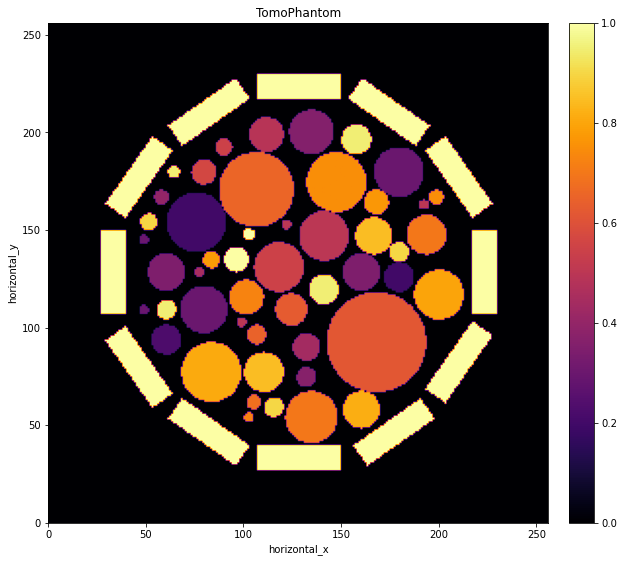

In [2]:
model = 12 # select a model number from the library
N = 256 # set dimension of the phantom
path = os.path.dirname(tomophantom.__file__)
path_library2D = os.path.join(path, "Phantom2DLibrary.dat")

phantom = TomoP2D.Model(model, N, path_library2D) 

# Define image geometry.
ig = ImageGeometry(voxel_num_x = N, voxel_num_y = N, 
                   voxel_size_x = 0.1,
                   voxel_size_y = 0.1)
im_data = ig.allocate()
im_data.fill(phantom)

show2D(im_data, title = 'TomoPhantom', cmap = 'inferno')

<a id='noise'></a>
The next step is to create an __AcquisitionGeometry__ and __AcquisitionData__ using a __Projection Operator__ $A$.

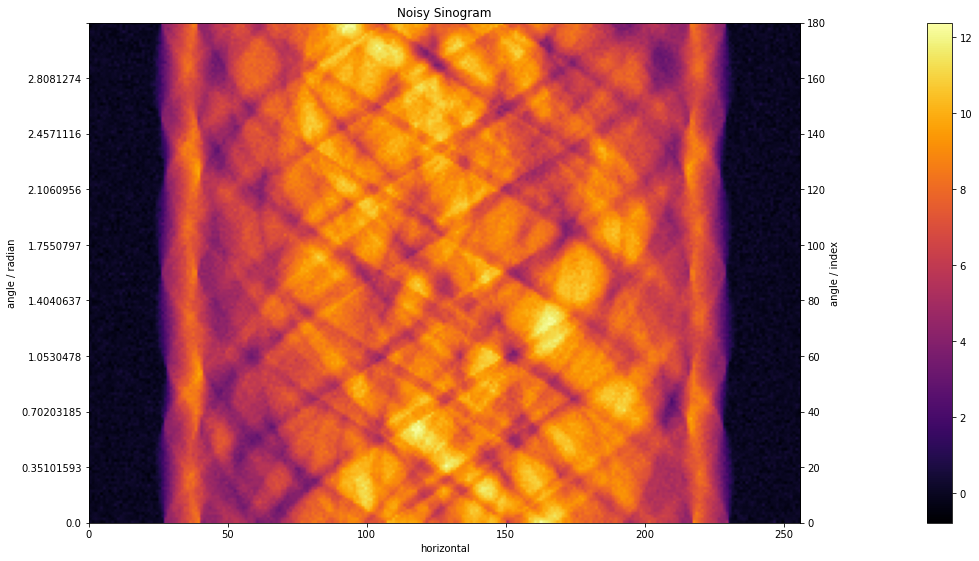

In [3]:
# Create AcquisitionGeometry and AcquisitionData 
numDetectors = N
pixelSize = 0.1
angles = np.linspace(0, np.pi, 180, dtype='float32')
ag = AcquisitionGeometry.create_Parallel2D().set_angles(angles, angle_unit = 'radian').set_panel(numDetectors, pixelSize)

# Create projection operator using Astra-Toolbox. Available CPU/CPU
A = ProjectionOperator(ig, ag, device = 'gpu')

# Create an acqusition data (numerically)
sino_num = A.direct(im_data)

# Show numerical sinogram
#show2D(sino_num, title = 'Numerical Sinogram', cmap = 'inferno')

# Simulate Gaussian noise for the sinogram
gaussian_var = 0.2
gaussian_mean = 0 # or np.mean(sino_num.as_array())
n1 = np.random.normal(gaussian_mean, gaussian_var, size = ag.shape)
                      
data = ag.allocate()
data.fill(n1 + sino_num.as_array())
show2D(data, title = 'Noisy Sinogram', cmap = 'inferno')

## How to setup and run SPDHG

In order to setup and run SPDHG, we need to define the following:

- The operator $K=(K_1,\dots,K_n)$.
- The functions $F=(F_1,\dots,f_N)$ and $G$.
- The maximum number of iterations

The setup and run of SPDHG:

` spdhg = SPDHG(f = F, g = G, operator = K, max_iteration = max_iteration)`

` spdhg.run()`

We can express our [problem](#TomoTV) into this [form](#SPDHG_form), if we let

1. $K = (A_1,\dots,A_n) \quad \Longleftrightarrow \quad $ `K = BlockOperator(A_i)`  

1. $F_i: Y_i \rightarrow \mathbb{R}, \mbox{ with } F_i(y_i) := \frac{1}{2}\| y_i - g_i \|^{2}, \quad \Longleftrightarrow \quad$ for all $i$'s, `F_i = 0.5 * L2NormSquared(data[i])` and  `F = BlockFunction(F_i)` 

1. $G: X \rightarrow \mathbb{R}, \mbox{ with } G(x) := \alpha\|\nabla x\|_{1} + \mathbb{I}_{\{x>0\}}(x), \quad \Longleftrightarrow \quad$ ` G = FGP_TV`.

### Define operator $K$, functions $F$  and $G$

In [4]:
# Define number of subsets
n_subsets = 10

# Divide the data into subsets
data_subsets = [Slicer(roi={'angle':(i,len(angles),n_subsets)})(data) for i in range(n_subsets)]

# Form the list of $F_i$'s and $F$
f_subsets = [0.5*L2NormSquared(b = data_subsets[i]) for i in range(n_subsets)]
F = BlockFunction(*f_subsets)

# Form the list of $A_i$'s and $K$
geometries_subsets = [ag.geometry for ag in data_subsets ]
A_subsets = [ProjectionOperator(ig, ageom) for ageom in geometries_subsets]
K = BlockOperator(*A_subsets)

# Define G (by default the positivity constraint is on)
alpha = 0.5
G = alpha * FGP_TV()

### Setup and run SPDHG

In [5]:
# Setup and run SPDHG
spdhg = SPDHG(f = F, g = G, operator = K,  max_iteration = 50,
            update_objective_interval = 100)
spdhg.run()

spdhg_recon = spdhg.get_output()     

SPDHG setting up
SPDHG configured
     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0         50         0.000          1.03136e+06
-------------------------------------------------------
       50         50         0.048                     
Stop criterion has been reached.



### Show reconstruction result

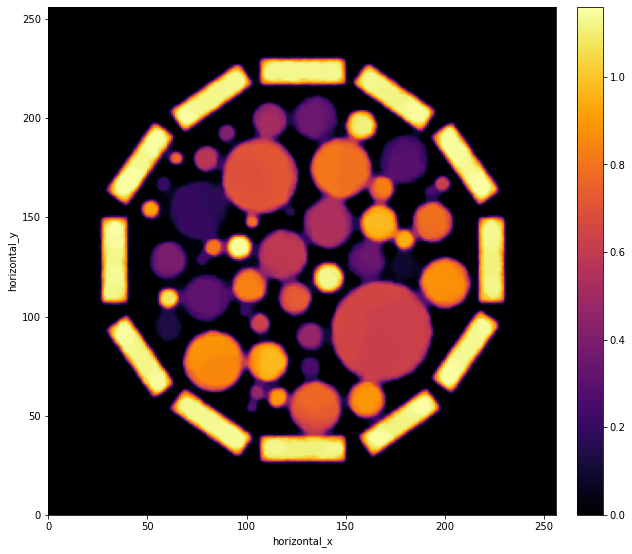

In [6]:
show2D(spdhg_recon, cmap='inferno')